In [1]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, lpDot, value, LpStatus

data = pd.read_excel("预处理后的数据.xlsx")
required_columns = ["作物名称", "平均价", "亩产量/斤", "种植成本/(元/亩)", "作物类型"]
if not all(col in data.columns for col in required_columns):
    raise ValueError("数据缺少必要的列")

data["预计销售量"] = data.groupby("作物名称")["种植面积/亩"].transform("sum")

years = range(2024, 2031)
crops = data["作物名称"].unique()
plots = data["地块名称"].unique()

# 线性约束
prob1_1 = LpProblem("Problem_1_1", LpMaximize)
prob1_2 = LpProblem("Problem_1_2", LpMaximize)
x1_1 = LpVariable.dicts("x1_1", [(i, j, t) for i in plots for j in crops for t in years], lowBound=0, cat='Continuous')
x1_2 = LpVariable.dicts("x1_2", [(i, j, t) for i in plots for j in crops for t in years], lowBound=0, cat='Continuous')

# 目标函数
for j in crops:
    for t in years:
        crop_data = data.loc[data["作物名称"] == j].iloc[0]
        profit_per_unit = crop_data["平均价"] * crop_data["亩产量/斤"] - crop_data["种植成本/(元/亩)"]
        total_production = lpDot([x1_2[i, j, t] for i in plots], crop_data["亩产量/斤"])
        excess = total_production - crop_data["预计销售量"]

        # 设置 prob1_1 的目标函数
        if prob1_1.objective is None:
            prob1_1 += lpDot([x1_1[i, j, t] for i in plots], profit_per_unit)

        # 设置 prob1_2 的目标函数
        if prob1_2.objective is None:
            prob1_2 += profit_per_unit * total_production - 0.5 * crop_data["平均价"] * excess

# 耕地资源
for t in years:
    prob1_1 += lpSum([x1_1[i, j, t] for i in plots for j in crops]) <= 1201
    prob1_2 += lpSum([x1_2[i, j, t] for i in plots for j in crops]) <= 1201

# 种植间作
for i in plots:
    for t in years:
        grain_crops = [j for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食")]
        prob1_1 += lpSum([x1_1[i, j, t] for j in grain_crops]) <= 1
        prob1_2 += lpSum([x1_2[i, j, t] for j in grain_crops]) <= 1

# 豆类作物轮作
for i in plots:
    for t in years:
        if t <= 2026:
            prob1_1 += lpSum([x1_1[i, j, t] for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食（豆类）")]) >= 1
            prob1_2 += lpSum([x1_2[i, j, t] for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食（豆类）")]) >= 1

for i in plots:
    if data.loc[data["地块名称"] == i, "地块类型"].values[0] == "水浇地":
        for t in years:
            prob1_1 += lpSum([x1_1[i, j, t] for j in crops if j == "水稻" or data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("蔬菜")]) <= 1
            prob1_2 += lpSum([x1_2[i, j, t] for j in crops if j == "水稻" or data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("蔬菜")]) <= 1
    else:
        for t in years:
            prob1_1 += lpSum([x1_1[i, j, t] for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食") and j!= "水稻"]) <= 1
            prob1_2 += lpSum([x1_2[i, j, t] for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食") and j!= "水稻"]) <= 1

for j in crops:
    for t in years:
        if not data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食（豆类）"):
            prob1_1 += lpSum([x1_1[i, j, t] for i in plots]) >= 30
            prob1_2 += lpSum([x1_2[i, j, t] for i in plots]) >= 30

for j in crops:
    for t in years:
        if not data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食"):
            prob1_1 += lpSum([x1_1[i, j, t] for i in plots]) >= 20
            prob1_2 += lpSum([x1_2[i, j, t] for i in plots]) >= 20

for i in plots:
    for t in years:
        prob1_1 += lpSum([x1_1[i, j, t] for j in crops]) >= 0.6
        prob1_2 += lpSum([x1_2[i, j, t] for j in crops]) >= 0.6

# 求解问题
prob1_1.solve()
prob1_2.solve()

# 检查求解器的状态
print("Status for Problem 1_1:", LpStatus[prob1_1.status])
print("Status for Problem 1_2:", LpStatus[prob1_2.status])

# 提取结果
result1_1 = pd.DataFrame([(i, j, t, value(x1_1[i, j, t])) for i in plots for j in crops for t in years if value(x1_1[i, j, t]) > 0], columns=["地块名称", "作物名称", "年份", "种植面积/亩"])
result1_2 = pd.DataFrame([(i, j, t, value(x1_2[i, j, t])) for i in plots for j in crops for t in years if value(x1_2[i, j, t]) > 0], columns=["地块名称", "作物名称", "年份", "种植面积/亩"])

two_season = ["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8",
                    "E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8",
                    "E9", "E10", "E11", "E12", "E13", "E14", "E15", "E16",
                    "F1", "F2", "F3", "F4"]

# print(two_season)
result1_1 = result1_1.rename(columns={"地块名称": "地块名称"})
result1_1_two_season = result1_1[result1_1["地块名称"].isin(two_season)]

season1_df = result1_1_two_season[result1_1_two_season["地块名称"].isin(two_season) & (result1_1_two_season["年份"] % 2 == 0)].copy()
season1_df['季节'] = "第一季"

season2_df = result1_1_two_season[result1_1_two_season["地块名称"].isin(two_season) & (result1_1_two_season["年份"] % 2 == 1)].copy()
season2_df['季节'] = "第二季"

result1_1_two_season = pd.concat([season1_df, season2_df])

season1_df_other = result1_1[~result1_1["地块名称"].isin(two_season)].copy()
season1_df_other['季节'] = "第一季"

# 合并所有数据
result1_1 = pd.concat([season1_df_other, result1_1_two_season])
result1_1.reset_index(drop=True, inplace=True)

# print(result1_1)

# 整理结果
result1_1_formatted = {}
result1_2_formatted = {}
for t in years:
    result1_1_formatted[t] = pd.DataFrame(0, index=plots, columns=crops)
    result1_2_formatted[t] = pd.DataFrame(0, index=plots, columns=crops)

for _, row in result1_1.iterrows():
    plot_name = row["地块名称"]
    crop_name = row["作物名称"]
    year = row["年份"]
    planting_area = row["种植面积/亩"]
    result1_1_formatted[year].loc[plot_name, crop_name] += planting_area

for _, row in result1_2.iterrows():
    plot_name = row["地块名称"]
    crop_name = row["作物名称"]
    year = row["年份"]
    planting_area = row["种植面积/亩"]
    result1_2_formatted[year].loc[plot_name, crop_name] += planting_area

# with pd.ExcelWriter("result1_1_1.xlsx") as writer:
#     for t, df in result1_1_formatted.items():
#         df.to_excel(writer, sheet_name=str(t))

# with pd.ExcelWriter("result1_2_2.xlsx") as writer:
#     for t, df in result1_2_formatted.items():
#         df.to_excel(writer, sheet_name=str(t))




# 在现实生活中，各种农作物之间可能存在一定的可替代性和互补性，预期销售量与销售价格、种植成本之间也存在一定的相关性。

def pass():
    result1_1_formatted = {}
result1_2_formatted = {}
for t in years:
    result1_1_formatted[t] = pd.DataFrame(0, index=plots, columns=crops)
    result1_2_formatted[t] = pd.DataFrame(0, index=plots, columns=crops)
    github://shellcode.com


# qkmkl



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/w/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9a1015001216471da3c3ab8331b5b08b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/9a1015001216471da3c3ab8331b5b08b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1721 COLUMNS
At line 67182 RHS
At line 68899 BOUNDS
At line 68900 ENDATA
Problem MODEL has 1716 rows, 15120 columns and 65406 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
Perturbing problem by 0.001% of 2350 - largest nonzero change 0.012464249 ( 0.00053039356%) - largest zero change 0.011799551
0  Obj -0 Primal inf 11098.8 (953) Dual inf 126899.51 (54)
109  Obj 139573.89 Primal inf 9714.7999 (1125)
218  Obj 139565.88 Primal inf

/tmp/ipykernel_335010/3693038848.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result1_1_formatted[year].loc[plot_name, crop_name] += planting_area
/tmp/ipykernel_335010/3693038848.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result1_1_formatted[year].loc[plot_name, crop_name] += planting_area
/tmp/ipykernel_335010/3693038848.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result1_1_formatted[year].loc[plot_name, crop_name] += planting_area
/

/home/w/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/w/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/w/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39292 (\N{CJK UNIFIED IDEOGRAPH-997C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/w/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/w/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31918 (\N{CJK UNIFIED IDEOGRAPH-7CAE}) missing from font(s) DejaV

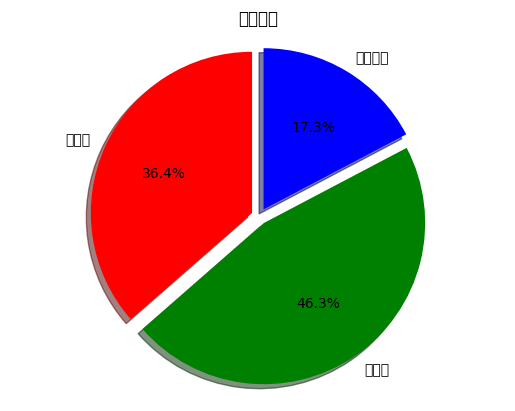

In [2]:
import matplotlib.pyplot as plt

# 数据
labels = ['粮食类', '蔬菜类', '食用菌类']
sizes = [36.44, 46.27, 17.29]
colors = ['red', 'green', 'blue']
explode = (0.05, 0.05, 0.05)  
# 绘制饼图
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')  
plt.title('二维饼图')

# 显示图形
plt.show()
